# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [67]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [68]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning).

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [69]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [70]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [71]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [72]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [73]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6381
F1-Score: 0.4513
Epoch 00002 | Loss: 0.5807
Epoch 00003 | Loss: 0.5616
Epoch 00004 | Loss: 0.5556
Epoch 00005 | Loss: 0.5506
Epoch 00006 | Loss: 0.5461
F1-Score: 0.5077
Epoch 00007 | Loss: 0.5420
Epoch 00008 | Loss: 0.5376
Epoch 00009 | Loss: 0.5339
Epoch 00010 | Loss: 0.5312
Epoch 00011 | Loss: 0.5285
F1-Score: 0.5228
Epoch 00012 | Loss: 0.5259
Epoch 00013 | Loss: 0.5235
Epoch 00014 | Loss: 0.5211
Epoch 00015 | Loss: 0.5189
Epoch 00016 | Loss: 0.5167
F1-Score: 0.5371
Epoch 00017 | Loss: 0.5146
Epoch 00018 | Loss: 0.5126
Epoch 00019 | Loss: 0.5107
Epoch 00020 | Loss: 0.5089
Epoch 00021 | Loss: 0.5072
F1-Score: 0.5076
Epoch 00022 | Loss: 0.5055
Epoch 00023 | Loss: 0.5026
Epoch 00024 | Loss: 0.5005
Epoch 00025 | Loss: 0.4987
Epoch 00026 | Loss: 0.4968
F1-Score: 0.5327
Epoch 00027 | Loss: 0.4948
Epoch 00028 | Loss: 0.4928
Epoch 00029 | Loss: 0.4905
Epoch 00030 | Loss: 0.4887
Epoch 00031 | Loss: 0.4869
F1-Score: 0.5494
Epoch 00032 | Loss: 0.4853
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6635


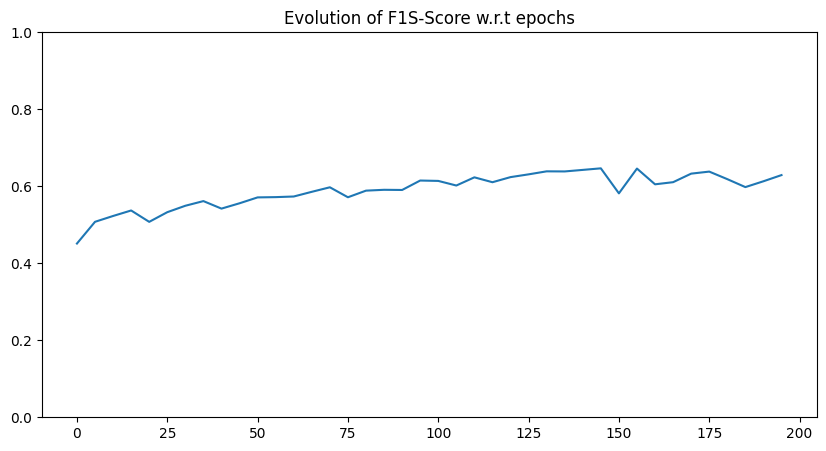

In [74]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

#GAT Transductive Learning Model (As thesis purposed)

In [ ]:
from torch_geometric.nn import GATConv

In [60]:
class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      super().__init__()

      ####### YOUR ANSWER #######
      # Define the first Graph Attention layer
      self.gatconv1 = graphnn.GATConv(input_size, hidden_size, heads=8, dropout=0.6)
      # Define the second Graph Attention layer
      self.gatconv2 = graphnn.GATConv(8*hidden_size, hidden_size, heads=8, concat=False, dropout=0.6)
      # Linear layer for multi-label classification
      self.linear = nn.Linear(hidden_size, output_size)

      self.elu = nn.ELU()
      self.sigmoid = nn.Sigmoid()

  def forward(self, x, edge_index):

      ####### YOUR ANSWER #######
      x = self.gatconv1(x, edge_index)
      x = self.elu(x)
      x = self.gatconv2(x, edge_index)
      x = self.elu(x)
      x = self.linear(x)
      return x

Let's train your model !

In [25]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.5937
F1-Score: 0.4149
Epoch 00002 | Loss: 0.5391
Epoch 00003 | Loss: 0.5270
Epoch 00004 | Loss: 0.5167
Epoch 00005 | Loss: 0.5117
Epoch 00006 | Loss: 0.5062
F1-Score: 0.4747
Epoch 00007 | Loss: 0.4993
Epoch 00008 | Loss: 0.4993
Epoch 00009 | Loss: 0.4990
Epoch 00010 | Loss: 0.4927
Epoch 00011 | Loss: 0.4877
F1-Score: 0.5552
Epoch 00012 | Loss: 0.4848
Epoch 00013 | Loss: 0.4836
Epoch 00014 | Loss: 0.4805
Epoch 00015 | Loss: 0.4801
Epoch 00016 | Loss: 0.4780
F1-Score: 0.5742
Epoch 00017 | Loss: 0.4754
Epoch 00018 | Loss: 0.4734
Epoch 00019 | Loss: 0.4698
Epoch 00020 | Loss: 0.4680
Epoch 00021 | Loss: 0.4665
F1-Score: 0.6047
Epoch 00022 | Loss: 0.4642
Epoch 00023 | Loss: 0.4628
Epoch 00024 | Loss: 0.4597
Epoch 00025 | Loss: 0.4584
Epoch 00026 | Loss: 0.4539
F1-Score: 0.6133
Epoch 00027 | Loss: 0.4518
Epoch 00028 | Loss: 0.4517
Epoch 00029 | Loss: 0.4510
Epoch 00030 | Loss: 0.4492
Epoch 00031 | Loss: 0.4450
F1-Score: 0.6213
Epoch 00032 | Loss: 0.4432
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.7169


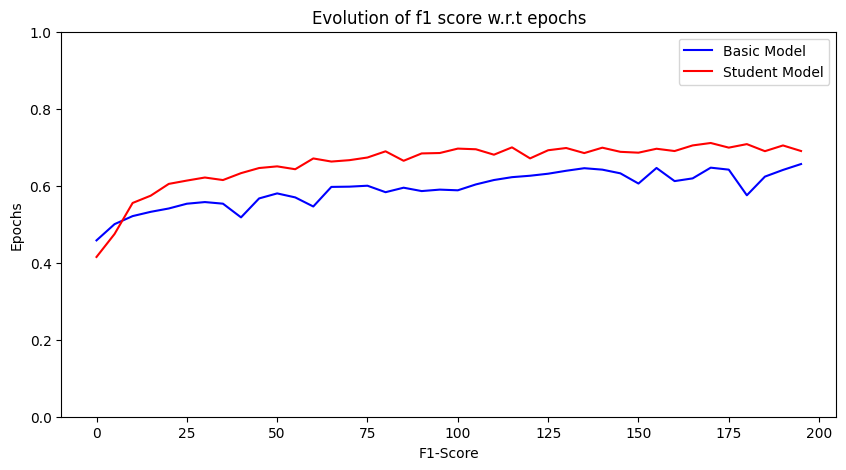

In [26]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

#GAT Model (Self Tuning according to Inductive Learning structure from thesis)

In [77]:
class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        num_heads = 4

        # GAT layers
        self.gat1 = GATConv(input_size, hidden_size, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_size * num_heads, hidden_size, heads=num_heads, concat=True)
        self.gat3 = GATConv(hidden_size * num_heads, output_size, heads=1, concat=False)

        # Activation
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.leaky_relu(self.gat1(x, edge_index))
        # Second GAT layer
        x = self.leaky_relu(self.gat2(x, edge_index))
        # Third GAT layer for classification
        x = self.gat3(x, edge_index)
        return x

In [80]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=350, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.5756
F1-Score: 0.3542
Epoch 00002 | Loss: 0.5575
Epoch 00003 | Loss: 0.5479
Epoch 00004 | Loss: 0.5366
Epoch 00005 | Loss: 0.5344
Epoch 00006 | Loss: 0.5252
F1-Score: 0.4888
Epoch 00007 | Loss: 0.5197
Epoch 00008 | Loss: 0.5113
Epoch 00009 | Loss: 0.5050
Epoch 00010 | Loss: 0.4964
Epoch 00011 | Loss: 0.4899
F1-Score: 0.4820
Epoch 00012 | Loss: 0.4886
Epoch 00013 | Loss: 0.4846
Epoch 00014 | Loss: 0.4792
Epoch 00015 | Loss: 0.4733
Epoch 00016 | Loss: 0.4654
F1-Score: 0.5565
Epoch 00017 | Loss: 0.4564
Epoch 00018 | Loss: 0.4494
Epoch 00019 | Loss: 0.4448
Epoch 00020 | Loss: 0.4405
Epoch 00021 | Loss: 0.4565
F1-Score: 0.5217
Epoch 00022 | Loss: 0.4444
Epoch 00023 | Loss: 0.4335
Epoch 00024 | Loss: 0.4238
Epoch 00025 | Loss: 0.4184
Epoch 00026 | Loss: 0.4164
F1-Score: 0.6376
Epoch 00027 | Loss: 0.4198
Epoch 00028 | Loss: 0.4137
Epoch 00029 | Loss: 0.4087
Epoch 00030 | Loss: 0.4040
Epoch 00031 | Loss: 0.4040
F1-Score: 0.6492
Epoch 00032 | Loss: 0.4011
Epoch 00033 | Los

Student Model : F1-Score on the test set: 0.8005


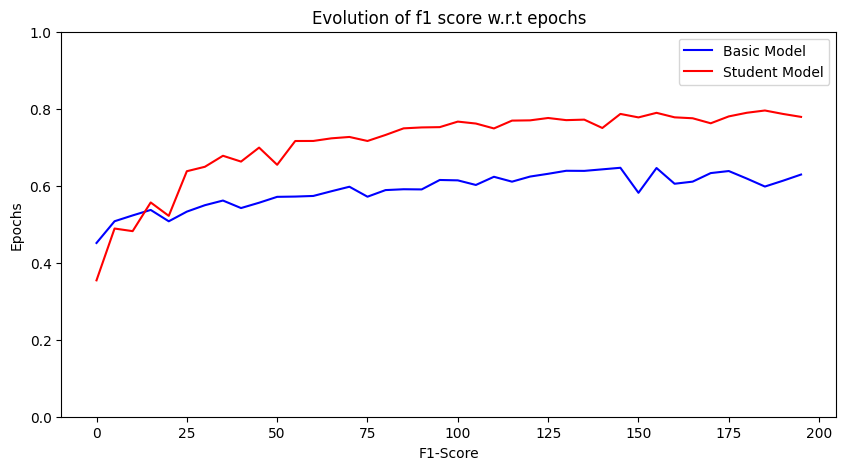

In [81]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

With 300 epochs (baseline is 200 epochs)

In [82]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=350, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, 300, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6248
F1-Score: 0.4268
Epoch 00002 | Loss: 0.5570
Epoch 00003 | Loss: 0.5519
Epoch 00004 | Loss: 0.5508
Epoch 00005 | Loss: 0.5409
Epoch 00006 | Loss: 0.5329
F1-Score: 0.4645
Epoch 00007 | Loss: 0.5268
Epoch 00008 | Loss: 0.5217
Epoch 00009 | Loss: 0.5165
Epoch 00010 | Loss: 0.5232
Epoch 00011 | Loss: 0.5168
F1-Score: 0.5088
Epoch 00012 | Loss: 0.5084
Epoch 00013 | Loss: 0.5008
Epoch 00014 | Loss: 0.4936
Epoch 00015 | Loss: 0.4904
Epoch 00016 | Loss: 0.4860
F1-Score: 0.5039
Epoch 00017 | Loss: 0.4831
Epoch 00018 | Loss: 0.4808
Epoch 00019 | Loss: 0.4759
Epoch 00020 | Loss: 0.4703
Epoch 00021 | Loss: 0.4638
F1-Score: 0.5719
Epoch 00022 | Loss: 0.4588
Epoch 00023 | Loss: 0.4673
Epoch 00024 | Loss: 0.4606
Epoch 00025 | Loss: 0.4539
Epoch 00026 | Loss: 0.4518
F1-Score: 0.6059
Epoch 00027 | Loss: 0.4542
Epoch 00028 | Loss: 0.4554
Epoch 00029 | Loss: 0.4463
Epoch 00030 | Loss: 0.4339
Epoch 00031 | Loss: 0.4250
F1-Score: 0.6263
Epoch 00032 | Loss: 0.4212
Epoch 00033 | Los

Student Model : F1-Score on the test set: 0.8253


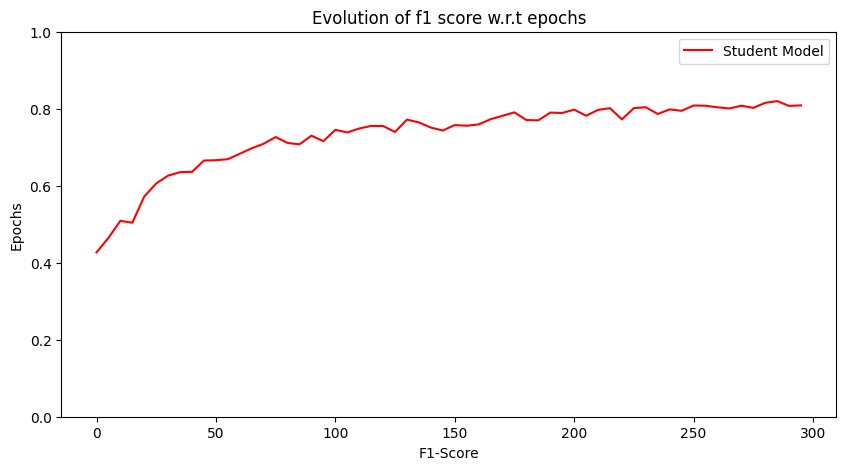

In [84]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

>Answer  

1. The chosen architecture for the classification task utilizes Graph Attention Networks (GATs) which have been selected for their ability to assign varying levels of importance to nodes within the network. Unlike the basic model's GCNLayer, which treats all neighbors equally, GAT layers weigh neighbors based on the attention mechanism, enabling the model to focus on the most relevant features. This adaptability is particularly beneficial in graph data where the significance of each node's connections can vary greatly, potentially leading to more nuanced and accurate classifications.  
  
2. The chart above indicates an improvement in F1-Score from the student model over the basic model. Furthermore, our student model achieved an F1-Score of 0.8253 on the test set. This demonstrates a considerable improvement over basic approaches and suggests that the attention mechanism in the GAT layers is effectively capturing the relationships in the PPI dataset. Although it doesn't reach the state-of-the-art F1-Score of 0.973 reported for the GAT model, it does outperform simpler models like MLP and GraphSAGE variations. The results are convincing as they show that the student model is robust and can provide meaningful predictions.



**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?
2. Are there solutions to overcome it ?
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

> Answer